In [1]:
# Install PyTorch and a convenient MLB stats data source library
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip -q install pybaseball
!pip -q install scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Pull a small Statcast sample via pybaseball.statcast() for initial exploration
import pandas as pd
from pybaseball import statcast

# A small window keeps the pull fast; adjust later once we validate the pipeline
start_date = "2024-04-01"
end_date = "2024-04-07"

sc = statcast(start_dt=start_date, end_dt=end_date)

print("Statcast sample shape:", sc.shape)
print("Columns (first 40):", list(sc.columns[:40]))
display(sc.head(5))

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]c:\Users\trent\OneDrive\Documents\Repositories\.venv\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
c:\Users\trent\OneDrive\Documents\Repositories\.venv\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
c:\Users\trent\OneDrive\Documents\Repositories\.venv\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datet

Statcast sample shape: (26072, 118)
Columns (first 40): ['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated']


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2625,CU,2024-04-07,85.2,-2.31,6.16,"Johnson, Pierce",664983,572955,field_out,hit_into_play,...,2,3.78,-0.73,0.73,36.0,21.26133,-9.620944,34.858224,44.484484,39.961796
2733,CU,2024-04-07,86.0,-2.33,6.15,"Johnson, Pierce",664983,572955,NaN,called_strike,...,2,3.52,-0.78,0.78,41.6,<NA>,<NA>,<NA>,<NA>,<NA>
2794,CU,2024-04-07,85.8,-2.27,6.2,"Johnson, Pierce",553993,572955,field_out,hit_into_play,...,1,3.49,-0.91,-0.91,42.2,14.211988,7.795369,34.318302,45.151528,27.733033
2886,CU,2024-04-07,86.5,-2.3,6.24,"Johnson, Pierce",572233,572955,single,hit_into_play,...,1,3.39,-0.9,-0.9,38.3,4.061736,9.400294,24.872673,33.739691,28.735222
3005,CU,2024-04-07,86.1,-2.18,6.16,"Johnson, Pierce",572233,572955,NaN,ball,...,1,3.51,-1.14,-1.14,40.2,<NA>,<NA>,<NA>,<NA>,<NA>


In [3]:
# Basic EDA: define a whiff label from Statcast pitch `description` and inspect data quality
import numpy as np
import pandas as pd

# Peek at the pitch outcome taxonomy present in this sample
print("Unique description count:", sc['description'].nunique(dropna=True))
print("Top 20 descriptions:\n", sc['description'].value_counts(dropna=False).head(20))

# Define a simple whiff label: swinging strike variants
whiff_descriptions = {
    'swinging_strike',
    'swinging_strike_blocked',
}
sc = sc.copy()
sc['is_whiff'] = sc['description'].isin(whiff_descriptions).astype('int8')

print("\nWhiff rate overall:", sc['is_whiff'].mean().round(4), "(n=", len(sc), ")")

# Check missingness for a minimal, interpretable feature set
feature_cols = [
    'pitch_type','release_speed','pfx_x','pfx_z','plate_x','plate_z',
    'balls','strikes','stand','p_throws','release_pos_x','release_pos_z'
]
missing = (sc[feature_cols].isna().mean().sort_values(ascending=False))
print("\nMissingness (fraction) for candidate features:\n", missing)

# Show a few raw rows including label + key features
display(sc[feature_cols + ['description','is_whiff']].sample(8, random_state=7))

# Quick numeric summaries to spot outliers / weird ranges
num_cols = ['release_speed','pfx_x','pfx_z','plate_x','plate_z','release_pos_x','release_pos_z']
display(sc[num_cols].describe(percentiles=[.01,.05,.5,.95,.99]).T)

Unique description count: 15
Top 20 descriptions:
 description
ball                       8723
foul                       4556
hit_into_play              4452
called_strike              4410
swinging_strike            2644
blocked_ball                633
foul_tip                    295
swinging_strike_blocked     135
hit_by_pitch                 83
automatic_ball               83
foul_bunt                    40
automatic_strike             10
missed_bunt                   6
bunt_foul_tip                 1
pitchout                      1
Name: count, dtype: int64

Whiff rate overall: 0.1066 (n= 26072 )

Missingness (fraction) for candidate features:
 pitch_type       0.003644
release_speed    0.003567
pfx_x            0.003567
pfx_z            0.003567
plate_x          0.003567
plate_z          0.003567
release_pos_x    0.003567
release_pos_z    0.003567
strikes          0.000000
balls            0.000000
p_throws         0.000000
stand            0.000000
dtype: float64


,pitch_type,release_speed,pfx_x,pfx_z,plate_x,plate_z,balls,strikes,stand,p_throws,release_pos_x,release_pos_z,description,is_whiff
1208,KC,80.6,0.07,-0.24,-0.35,1.26,0,2,R,L,2.06,6.3,ball,0
668,FF,91.3,0.63,1.38,-0.38,3.8,3,2,L,L,1.73,5.51,swinging_strike,1
3282,FF,91.7,0.02,1.68,-0.21,2.66,0,0,L,R,-0.22,6.92,hit_into_play,0
976,FF,92.7,0.16,0.93,0.52,2.03,2,2,R,L,1.81,5.83,foul,0
672,KC,75.2,-0.91,-0.7,0.18,0.61,0,1,R,L,2.45,6.5,swinging_strike,1
1495,FF,93.6,-0.46,1.04,0.44,2.98,3,0,R,R,-2.34,5.76,called_strike,0
3280,ST,80.5,1.32,0.37,0.07,3.11,2,2,R,R,-1.04,6.19,foul_tip,0
2715,SI,91.6,-1.47,0.3,-0.86,2.9,1,0,R,R,-4.38,4.24,foul,0


,count,mean,std,min,1%,5%,50%,95%,99%,max
release_speed,25979.0,88.714862,5.866247,39.9,74.3,78.6,89.5,96.8,98.7,102.4
pfx_x,25979.0,-0.121336,0.921258,-2.95,-1.69,-1.48,-0.16,1.39,1.65,2.4
pfx_z,25979.0,0.610208,0.709276,-1.85,-1.3,-0.67,0.63,1.59,1.74,2.14
plate_x,25979.0,0.055496,0.828552,-3.79,-1.87,-1.31,0.05,1.41,2.03,3.81
plate_z,25979.0,2.291348,0.973069,-2.82,-0.1,0.68,2.31,3.86,4.54,8.0
release_pos_x,25979.0,-0.810267,1.845483,-4.51,-3.53,-2.91,-1.48,2.611,3.33,4.56
release_pos_z,25979.0,5.794603,0.519465,0.95,4.31,4.97,5.83,6.54,6.85,7.3


In [4]:
# Build a clean modeling table for a whiff model (features + label) and make a time-based split
import numpy as np
import pandas as pd

# Ensure game_date is datetime
sc_model = sc.copy()
sc_model['game_date'] = pd.to_datetime(sc_model['game_date'])

# Define features + target
feature_cols = [
    'pitch_type','release_speed','pfx_x','pfx_z','plate_x','plate_z',
    'balls','strikes','stand','p_throws','release_pos_x','release_pos_z'
]

target_col = 'is_whiff'

# Keep only rows with non-missing target and required features
needed_cols = feature_cols + [target_col, 'game_date']
df_model = sc_model[needed_cols].copy()

# Drop missing rows
before = len(df_model)
df_model = df_model.dropna(subset=feature_cols + [target_col])
after = len(df_model)
print(f"Rows before dropna: {before:,} | after: {after:,} | dropped: {before-after:,} ({(before-after)/before:.2%})")

# Cast types for categorical columns
cat_cols = ['pitch_type', 'stand', 'p_throws']
for c in cat_cols:
    df_model[c] = df_model[c].astype('category')

df_model[target_col] = df_model[target_col].astype('int8')

# Sort by date and make a simple time-based split (last day as test)
df_model = df_model.sort_values('game_date').reset_index(drop=True)
last_date = df_model['game_date'].max()
test_mask = df_model['game_date'].eq(last_date)

print("Date range:", df_model['game_date'].min().date(), "→", df_model['game_date'].max().date())
print("Train rows:", (~test_mask).sum(), "| Test rows:", test_mask.sum())
print("Train whiff rate:", df_model.loc[~test_mask, target_col].mean().round(4))
print("Test  whiff rate:", df_model.loc[test_mask, target_col].mean().round(4))

display(df_model.head())

# Expose split indices for downstream modeling cells
train_idx = np.flatnonzero(~test_mask)
test_idx = np.flatnonzero(test_mask)
print("train_idx/test_idx ready.")

Rows before dropna: 26,072 | after: 25,977 | dropped: 95 (0.36%)
Date range: 2024-04-01 → 2024-04-07
Train rows: 21938 | Test rows: 4039
Train whiff rate: 0.1083
Test  whiff rate: 0.1


,pitch_type,release_speed,pfx_x,pfx_z,plate_x,plate_z,balls,strikes,stand,p_throws,release_pos_x,release_pos_z,is_whiff,game_date
0,FF,97.3,0.71,1.55,0.16,1.75,0,0,R,L,2.14,5.78,0,2024-04-01
1,FF,94.0,-1.08,1.24,-1.17,2.7,1,0,L,R,-1.43,6.08,0,2024-04-01
2,FF,93.9,-0.82,1.31,-0.58,3.68,2,0,L,R,-1.36,6.17,0,2024-04-01
3,FF,93.7,-0.71,1.22,0.86,2.95,3,0,L,R,-1.28,6.16,0,2024-04-01
4,FF,92.9,-0.58,1.2,0.81,1.29,3,1,L,R,-1.21,6.1,0,2024-04-01


train_idx/test_idx ready.


In [ ]:
# Train a simple baseline model (logistic regression) to predict whiff probability
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss, classification_report

# Split data
X = df_model[feature_cols]
y = df_model[target_col].astype(int)
X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

cat_cols = ['pitch_type', 'stand', 'p_throws']
num_cols = [c for c in feature_cols if c not in cat_cols]

# Preprocessing: impute, scale numerics, one-hot encode categoricals
# Building columns into a single all-numeric matrix for modeling logistic regression and MLP
# will reuse this preprocessing for the PyTorch model
preprocess = ColumnTransformer(
    transformers=[
        (
            # For numeric features: median imputation + standard scaling
            'num',
            Pipeline(steps=[
                # Replace missing numeric values with the median of each column
                ('imputer', SimpleImputer(strategy='median')),
                # Z-score standard scaling
                ('scaler', StandardScaler()),
            ]),
            num_cols,
        ),
        (
            # For categorical features: most frequent imputation + one-hot encoding
            'cat',
            Pipeline(steps=[
                # Replace missing categorical values with the most frequent category in each column
                ('imputer', SimpleImputer(strategy='most_frequent')),
                # Turns categories into indicator columns (Pitch_type=FF, etc.). 
                # handle_unknown='ignore' ensures we can handle unseen categories in test set without error
                ('onehot', OneHotEncoder(handle_unknown='ignore')),
            ]),
            cat_cols,
        ),
    ],
    # Drop any columns not specified in transformers
    remainder='drop',
)
# A simple logistic regression with balanced class weights to handle any class imbalance and a higher max_iter to ensure convergence
clf = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    n_jobs=None,
    solver='lbfgs',
)

pipe = Pipeline(steps=[('preprocess', preprocess), ('model', clf)])

pipe.fit(X_train, y_train)

# Probabilities + metrics
yhat_train = pipe.predict_proba(X_train)[:, 1]
yhat_test = pipe.predict_proba(X_test)[:, 1]

metrics = {
    'train_auc': roc_auc_score(y_train, yhat_train),
    'test_auc': roc_auc_score(y_test, yhat_test),
    'train_logloss': log_loss(y_train, yhat_train, labels=[0, 1]),
    'test_logloss': log_loss(y_test, yhat_test, labels=[0, 1]),
    'train_brier': brier_score_loss(y_train, yhat_train),
    'test_brier': brier_score_loss(y_test, yhat_test),
}

print("Baseline logistic regression metrics:")
for k, v in metrics.items():
    print(f"  {k:>14}: {v:.4f}")

# Quick threshold report at 0.5 (not necessarily optimal; mostly for sanity)
print("\nClassification report on test (threshold=0.5):")
print(classification_report(y_test, (yhat_test >= 0.5).astype(int), digits=3))

# Expose for downstream use
baseline_pipe = pipe
baseline_yhat_test = yhat_test

Baseline logistic regression metrics:
       train_auc: 0.6210
        test_auc: 0.6081
   train_logloss: 0.6710
    test_logloss: 0.6648
     train_brier: 0.2391
      test_brier: 0.2361

Classification report on test (threshold=0.5):
              precision    recall  f1-score   support

           0      0.922     0.608     0.733      3635
           1      0.132     0.537     0.212       404

    accuracy                          0.601      4039
   macro avg      0.527     0.573     0.473      4039
weighted avg      0.843     0.601     0.681      4039



# Machine Learning Program Using PyTorch

In [ ]:
# Prepare torch tensors using the same preprocessing as the sklearn baseline
# Setup for PyTorch MLP model training and evaluation
import torch

# Reuse the fitted preprocessing from the baseline pipeline (fit on training data only)
pre = baseline_pipe.named_steps['preprocess']

X_train_np = pre.transform(X_train)
X_test_np = pre.transform(X_test)

# Ensure dense float32 matrices for PyTorch so we get rid of one-hot columns which have 0)
if hasattr(X_train_np, "toarray"):
    X_train_np = X_train_np.toarray()
    X_test_np = X_test_np.toarray()
# Ensure float32 for PyTorch
X_train_np = X_train_np.astype(np.float32)
X_test_np = X_test_np.astype(np.float32)
y_train_np = y_train.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.float32)
# Convert to torch tensors
X_train_t = torch.from_numpy(X_train_np)
X_test_t = torch.from_numpy(X_test_np)
y_train_t = torch.from_numpy(y_train_np).view(-1, 1)
y_test_t = torch.from_numpy(y_test_np).view(-1, 1)
# Sanity check tensor shapes and types
print("X_train_t:", tuple(X_train_t.shape), X_train_t.dtype)
print("X_test_t :", tuple(X_test_t.shape), X_test_t.dtype)
# Note: the whiff rate is low, so we want to confirm the label tensor looks reasonable before training a PyTorch model
print("y_train_t:", tuple(y_train_t.shape), y_train_t.dtype, "| whiff rate:", float(y_train_t.mean()))
print("y_test_t :", tuple(y_test_t.shape), y_test_t.dtype, "| whiff rate:", float(y_test_t.mean()))
# Number of input features after preprocessing (important for defining the first layer of the MLP)
input_dim = X_train_t.shape[1]
print("input_dim set to", input_dim)

X_train_t: (21938, 28) torch.float32
X_test_t : (4039, 28) torch.float32
y_train_t: (21938, 1) torch.float32 | whiff rate: 0.1082596406340599
y_test_t : (4039, 1) torch.float32 | whiff rate: 0.1000247597694397
input_dim set to 28


In [7]:
# Train a PyTorch MLP on the preprocessed tensors and evaluate on the test
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# Reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# DataLoaders
batch_size = 512
# We create TensorDatasets and DataLoaders for the training and test sets. 
# The training DataLoader is shuffled to help with optimization, while the test DataLoader is not shuffled 
# since we will evaluate on the entire test set at once.
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# MLP
class MLP(nn.Module):
    # Learns whiff probability from the preprocessed features. A simple architecture with one hidden layer, 
    # ReLU for non-linearity, and dropout of 10% to reduce overfitting.
    def __init__(self, input_dim: int, hidden_dim: int = 64, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            # Outputs single numeric value per input row representing the logit for the whiff probability. (1 per pitch)
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=input_dim, hidden_dim=64, dropout=0.1)

# Handle class imbalance via pos_weight = (#neg / #pos) to balance whiff vs non-whiff 
# This helps the model learn from the relatively rare whiff events without being overwhelmed by the more common non-whiffs.
num_pos = float(y_train_t.sum().item())
num_neg = float((y_train_t.shape[0] - y_train_t.sum()).item())
pos_weight = torch.tensor([num_neg / max(num_pos, 1.0)], dtype=torch.float32)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# AdamW optimizer with a small learning rate and weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Training loop (Number of full passes through the training data)
n_epochs = 10

# A helper function to get probability predictions from the model's logits for every pitch
def predict_proba_logits(m, X, bs=4096):
    m.eval()
    probs = []
    with torch.no_grad():
        for i in range(0, X.shape[0], bs):
            xb = X[i:i+bs]
            logits = m(xb)
            pb = torch.sigmoid(logits)
            probs.append(pb.cpu())
    return torch.cat(probs, dim=0).view(-1).numpy()

# Training loop with epoch-level metrics
for epoch in range(1, n_epochs + 1):
    # Standard training loop: iterate over batches, compute loss, backpropagate, and update weights.
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        # Clear gradients, forward pass, calculate weighted BCE loss, compute gradients by backpropagation, and update weights.
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running += float(loss.item()) * xb.shape[0]
# Average training loss for the epoch (total loss divided by number of training samples)
    train_loss = running / len(train_ds)

    # Quick epoch-level metrics using full-batch predictions (keep it simple at this scale)
    p_train = predict_proba_logits(model, X_train_t)
    p_test = predict_proba_logits(model, X_test_t)

    # Metrics (use sklearn)
    # Ranking metric: AUC (Area Under the ROC Curve) to evaluate how well the model ranks whiff vs non-whiff pitches.
    auc_train = roc_auc_score(y_train, p_train)
    auc_test = roc_auc_score(y_test, p_test)
    # Ranking metric: log loss to evaluate the quality of the predicted probabilities (lower is better, with 0 being perfect).
    ll_train = log_loss(y_train, p_train, labels=[0, 1])
    ll_test = log_loss(y_test, p_test, labels=[0, 1])

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | AUC train={auc_train:.4f} test={auc_test:.4f} | logloss train={ll_train:.4f} test={ll_test:.4f}")

# Final test-set probability predictions for later
mlp_yhat_test = predict_proba_logits(model, X_test_t)
print("\nSaved: model (PyTorch MLP) and mlp_yhat_test (test probabilities).")

Epoch 01 | train_loss=1.2270 | AUC train=0.5975 test=0.5884 | logloss train=0.6850 test=0.6855
Epoch 02 | train_loss=1.2081 | AUC train=0.6236 test=0.6188 | logloss train=0.6710 test=0.6703
Epoch 03 | train_loss=1.1947 | AUC train=0.6446 test=0.6402 | logloss train=0.6667 test=0.6655
Epoch 04 | train_loss=1.1822 | AUC train=0.6623 test=0.6582 | logloss train=0.6651 test=0.6625
Epoch 05 | train_loss=1.1683 | AUC train=0.6784 test=0.6736 | logloss train=0.6554 test=0.6511
Epoch 06 | train_loss=1.1541 | AUC train=0.6929 test=0.6890 | logloss train=0.6393 test=0.6343
Epoch 07 | train_loss=1.1401 | AUC train=0.7009 test=0.6972 | logloss train=0.6300 test=0.6237
Epoch 08 | train_loss=1.1339 | AUC train=0.7074 test=0.7032 | logloss train=0.6305 test=0.6234
Epoch 09 | train_loss=1.1229 | AUC train=0.7112 test=0.7068 | logloss train=0.6242 test=0.6165
Epoch 10 | train_loss=1.1161 | AUC train=0.7164 test=0.7105 | logloss train=0.6262 test=0.6179

Saved: model (PyTorch MLP) and mlp_yhat_test (tes

Test-set summary (higher AUC better; lower logloss/brier better):
- LogReg baseline: AUC=0.6081 | logloss=0.6648 | brier=0.2361 | mean(p)=0.4779 | p95=0.650 | p99=0.700
- PyTorch MLP: AUC=0.7105 | logloss=0.6179 | brier=0.2154 | mean(p)=0.4500 | p95=0.689 | p99=0.749


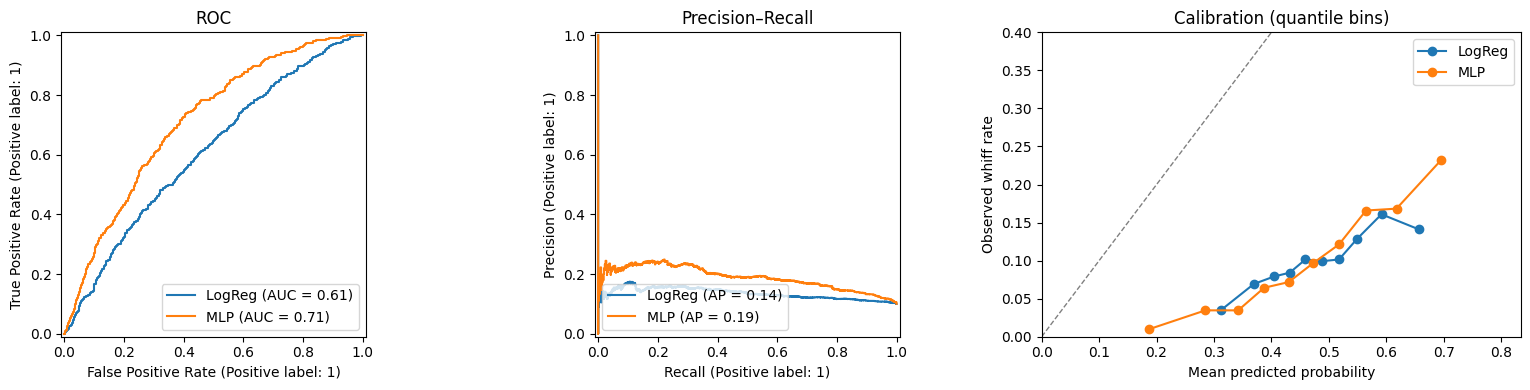

In [ ]:
# Compare sklearn logistic regression vs PyTorch MLP on the test data
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, log_loss, brier_score_loss,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import calibration_curve

# Probabilities
p_lr = baseline_yhat_test
p_mlp = mlp_yhat_test

def summarize_probs(y_true, p, name):
    return {
        'model': name,
        # Probability whiff pitch gets higher score than non-whiff pitch
        'auc': roc_auc_score(y_true, p),
        # quality of predicted probabilities (lower is better)
        'logloss': log_loss(y_true, p, labels=[0, 1]),
        # Mean squared error between predicted probabilities and actual outcomes (lower is better)
        'brier': brier_score_loss(y_true, p),
        # Distribution of predicted probabilities
        'p_mean': float(np.mean(p)),
        'p_p95': float(np.quantile(p, 0.95)),
        'p_p99': float(np.quantile(p, 0.99)),
    }

# Summarize test-set probabilities for both models
rows = [
    summarize_probs(y_test, p_lr, 'LogReg baseline'),
    summarize_probs(y_test, p_mlp, 'PyTorch MLP'),
]

print("Test-set summary (higher AUC better; lower logloss/brier better):")
for r in rows:
    print(
        f"- {r['model']}: AUC={r['auc']:.4f} | logloss={r['logloss']:.4f} | brier={r['brier']:.4f} | "
        f"mean(p)={r['p_mean']:.4f} | p95={r['p_p95']:.3f} | p99={r['p_p99']:.3f}"
    )

# Curves
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
# ROC curve to evaluate how well the model ranks whiff vs non-whiff pitches across all thresholds (higher AUC is better).
RocCurveDisplay.from_predictions(y_test, p_lr, name='LogReg', ax=axes[0])
RocCurveDisplay.from_predictions(y_test, p_mlp, name='MLP', ax=axes[0])
axes[0].set_title('ROC')
# Precision-recall curve to evaluate the tradeoff between precision and recall across thresholds (higher area under the curve is better)
# Whiffs are 10% of pitches, so we expect a baseline precision of 10% if we randomly guess. A good model should have a curve that bows up towards the top-right corner, indicating high precision and recall across thresholds.
PrecisionRecallDisplay.from_predictions(y_test, p_lr, name='LogReg', ax=axes[1])
PrecisionRecallDisplay.from_predictions(y_test, p_mlp, name='MLP', ax=axes[1])
axes[1].set_title('Precision–Recall')

# Calibration (reliability)
# Perfect calibration means that among all pitches that the model predicts with a certain probability p of being a whiff, 
# approximately p fraction of them should actually be whiffs.
# Should be a diagonal line
for p, name in [(p_lr, 'LogReg'), (p_mlp, 'MLP')]:
    frac_pos, mean_pred = calibration_curve(y_test, p, n_bins=10, strategy='quantile')
    axes[2].plot(mean_pred, frac_pos, marker='o', label=name)
axes[2].plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1)
axes[2].set_xlim(0, max(0.4, float(max(p_lr.max(), p_mlp.max()))))
axes[2].set_ylim(0, max(0.4, float(max(y_test.mean()*3, 0.3))))
axes[2].set_xlabel('Mean predicted probability')
axes[2].set_ylabel('Observed whiff rate')
axes[2].set_title('Calibration (quantile bins)')
axes[2].legend()

plt.tight_layout()
plt.show()

True test whiff rate: 0.1
Mean predicted prob (raw) - LogReg: 0.4779
Mean predicted prob (raw) - MLP   : 0.45

Calibration split within training:
  fit rows: 17,418
  cal rows: 4,520 (date=2024-04-06)

Test-day metrics (AUC should be ~unchanged; logloss/brier + mean(p) should improve if calibration helps):
- LogReg raw    AUC=0.6081 | logloss=0.6648 | brier=0.2361 | mean(p)=0.4779
- LogReg + Platt AUC=0.6081 | logloss=0.3192 | brier=0.0891 | mean(p)=0.1070
- MLP raw       AUC=0.7105 | logloss=0.6179 | brier=0.2154 | mean(p)=0.4500
- MLP + Platt   AUC=0.7105 | logloss=0.3003 | brier=0.0860 | mean(p)=0.1054


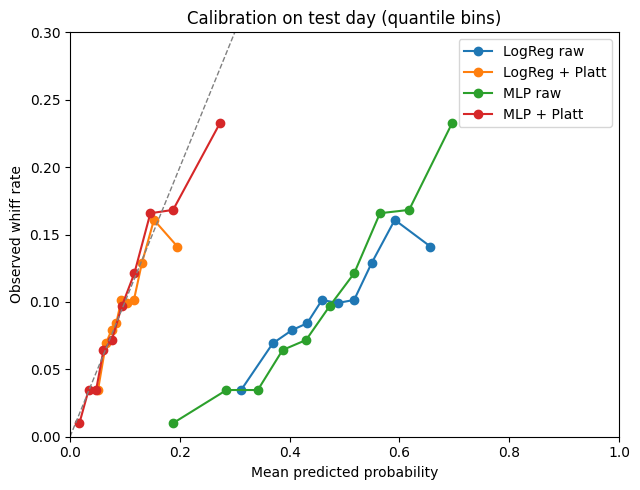

In [10]:
# Calibrate probability outputs (post-hoc) and re-evaluate calibration on the test day
# - Important because class imbalance weighting (pos_weight / class_weight) was used, which shifts probability calibration.

from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

# True labels
y_te = y_test.to_numpy(dtype=int)

# Raw probabilities from both models
p_lr_raw = baseline_yhat_test
p_mlp_raw = mlp_yhat_test

print("True test whiff rate:", round(float(y_te.mean()), 4))
print("Mean predicted prob (raw) - LogReg:", round(float(np.mean(p_lr_raw)), 4))
print("Mean predicted prob (raw) - MLP   :", round(float(np.mean(p_mlp_raw)), 4))

# --- Create a calibration split within training days (no leakage into test day) ---
# We'll use the last training date as calibration-valid, earlier dates for fitting calibrators.
train_dates = df_model.loc[train_idx, 'game_date']
cal_date = train_dates.max()  # last day before test day
cal_mask_train = (train_dates == cal_date).to_numpy()
fit_mask_train = ~cal_mask_train

# Get probabilities on *training rows* for both models
# Logistic regression: use pipe.predict_proba directly
p_lr_train_raw = baseline_pipe.predict_proba(X_train)[:, 1]

# MLP: use the helper over the training tensor
p_mlp_train_raw = predict_proba_logits(model, X_train_t)

y_tr = y_train.to_numpy(dtype=int)

# Split into fit vs calibration-valid
p_lr_fit, p_lr_cal = p_lr_train_raw[fit_mask_train], p_lr_train_raw[cal_mask_train]
p_mlp_fit, p_mlp_cal = p_mlp_train_raw[fit_mask_train], p_mlp_train_raw[cal_mask_train]
y_fit, y_cal = y_tr[fit_mask_train], y_tr[cal_mask_train]

print(f"\nCalibration split within training:\n  fit rows: {fit_mask_train.sum():,}\n  cal rows: {cal_mask_train.sum():,} (date={cal_date.date()})")

# --- Platt scaling (logistic calibration) for each model ---
# We fit a logistic regression on logit(p) -> y. This is a common, simple calibrator.

def logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

platt_lr = LogisticRegression(solver='lbfgs')
platt_mlp = LogisticRegression(solver='lbfgs')

platt_lr.fit(logit(p_lr_fit).reshape(-1, 1), y_fit)
platt_mlp.fit(logit(p_mlp_fit).reshape(-1, 1), y_fit)

p_lr_te_cal = platt_lr.predict_proba(logit(p_lr_raw).reshape(-1, 1))[:, 1]
p_mlp_te_cal = platt_mlp.predict_proba(logit(p_mlp_raw).reshape(-1, 1))[:, 1]

# --- Summarize metrics pre/post calibration ---

def summarize(y, p, label):
    return {
        'label': label,
        'auc': roc_auc_score(y, p),
        'logloss': log_loss(y, p, labels=[0, 1]),
        'brier': brier_score_loss(y, p),
        'mean_p': float(np.mean(p)),
    }

summaries = [
    summarize(y_te, p_lr_raw,  "LogReg raw"),
    summarize(y_te, p_lr_te_cal, "LogReg + Platt"),
    summarize(y_te, p_mlp_raw,  "MLP raw"),
    summarize(y_te, p_mlp_te_cal, "MLP + Platt"),
]

print("\nTest-day metrics (AUC should be ~unchanged; logloss/brier + mean(p) should improve if calibration helps):")
for s in summaries:
    print(f"- {s['label']:<13} AUC={s['auc']:.4f} | logloss={s['logloss']:.4f} | brier={s['brier']:.4f} | mean(p)={s['mean_p']:.4f}")

# --- Plot calibration curves (raw vs calibrated) ---
fig, ax = plt.subplots(1, 1, figsize=(6.5, 5))
for p, name in [
    (p_lr_raw, "LogReg raw"),
    (p_lr_te_cal, "LogReg + Platt"),
    (p_mlp_raw, "MLP raw"),
    (p_mlp_te_cal, "MLP + Platt"),
]:
    frac_pos, mean_pred = calibration_curve(y_te, p, n_bins=10, strategy='quantile')
    ax.plot(mean_pred, frac_pos, marker='o', linewidth=1.5, label=name)

ax.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1)
ax.set_title('Calibration on test day (quantile bins)')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Observed whiff rate')
ax.set_xlim(0, 1)
ax.set_ylim(0, max(0.3, y_te.mean() * 3))
ax.legend()
plt.tight_layout()
plt.show()